In [10]:
import utils
import skeletons
import keras
import glob
import models
import os
import numpy as np
utils = reload(utils)

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [11]:
# get h5 datasets
samples = glob.glob("../data/tightSVJ/*_data.h5")
loader = utils.data_loader("main sample")
for sample in samples:
    loader.add_sample(sample)

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/5_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/tightSVJ/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_

Note that we normalize our training/testing each with respect to the full data sample:

In [12]:
data = loader.make_table()
train, test = data.train_test_split(0.4)
train_norm, test_norm = data.norm(train), data.norm(test)
print train_norm.shape, test_norm.shape

data_loader :: Grabbing dataset with keys [u'event_feature_data']
(3370, 16) (2248, 16)


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['main sample', 'train', 'test']


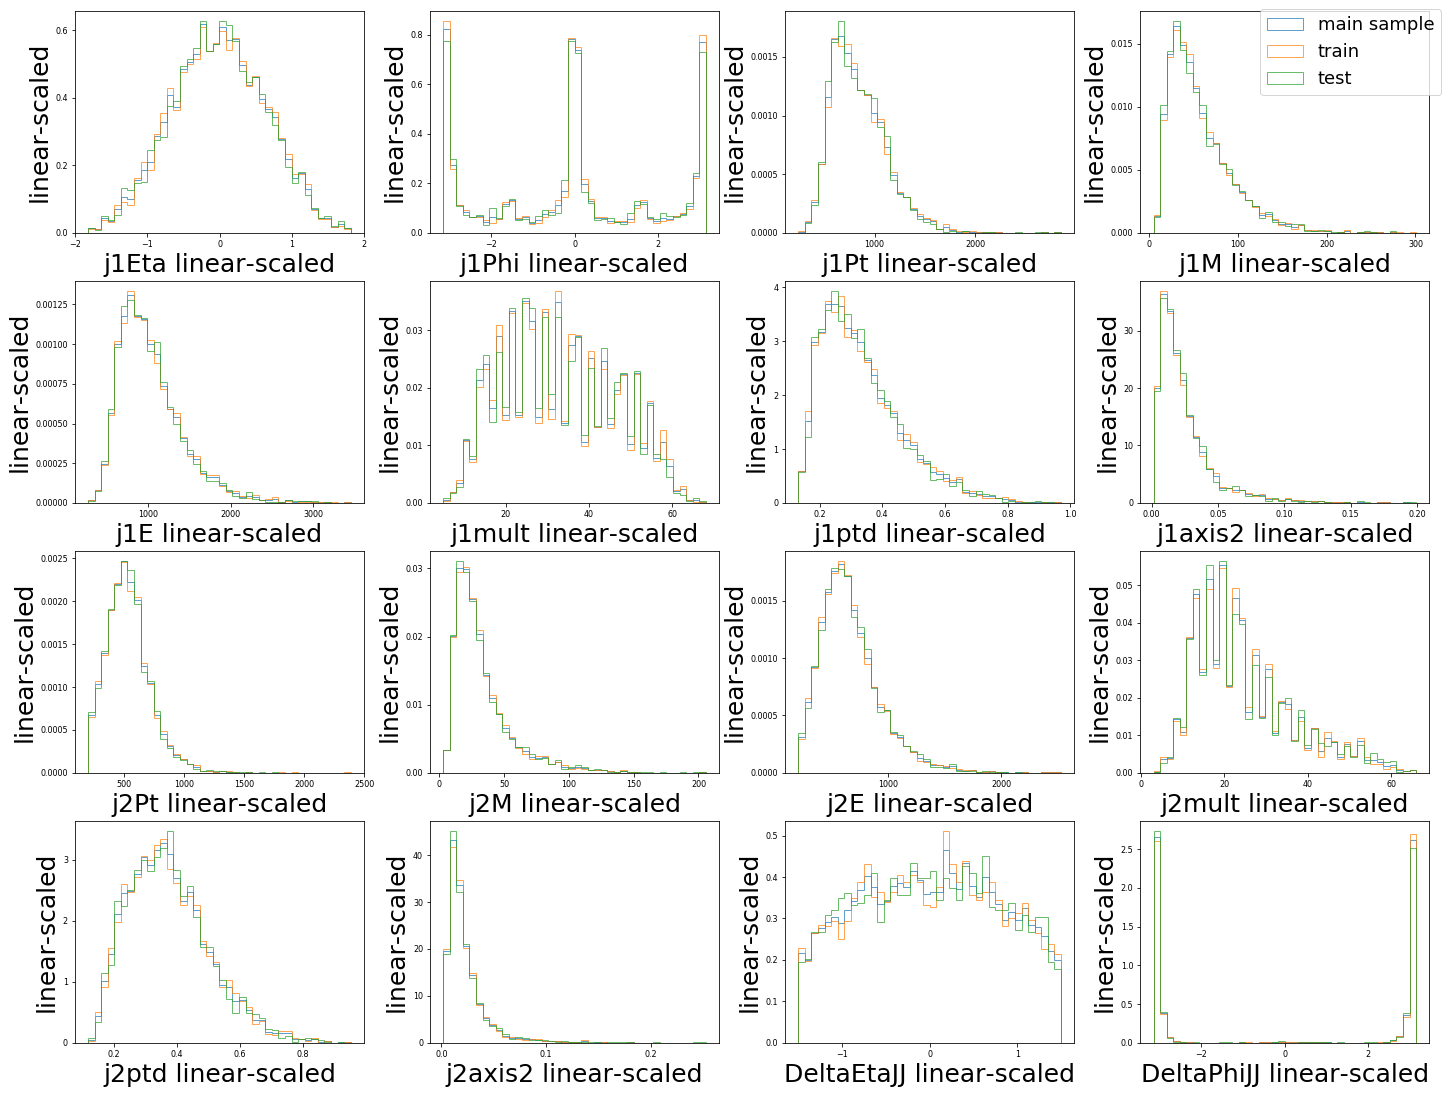

data_table :: plotting distrubution(s) for table(s) ['main sample', 'train', 'test']


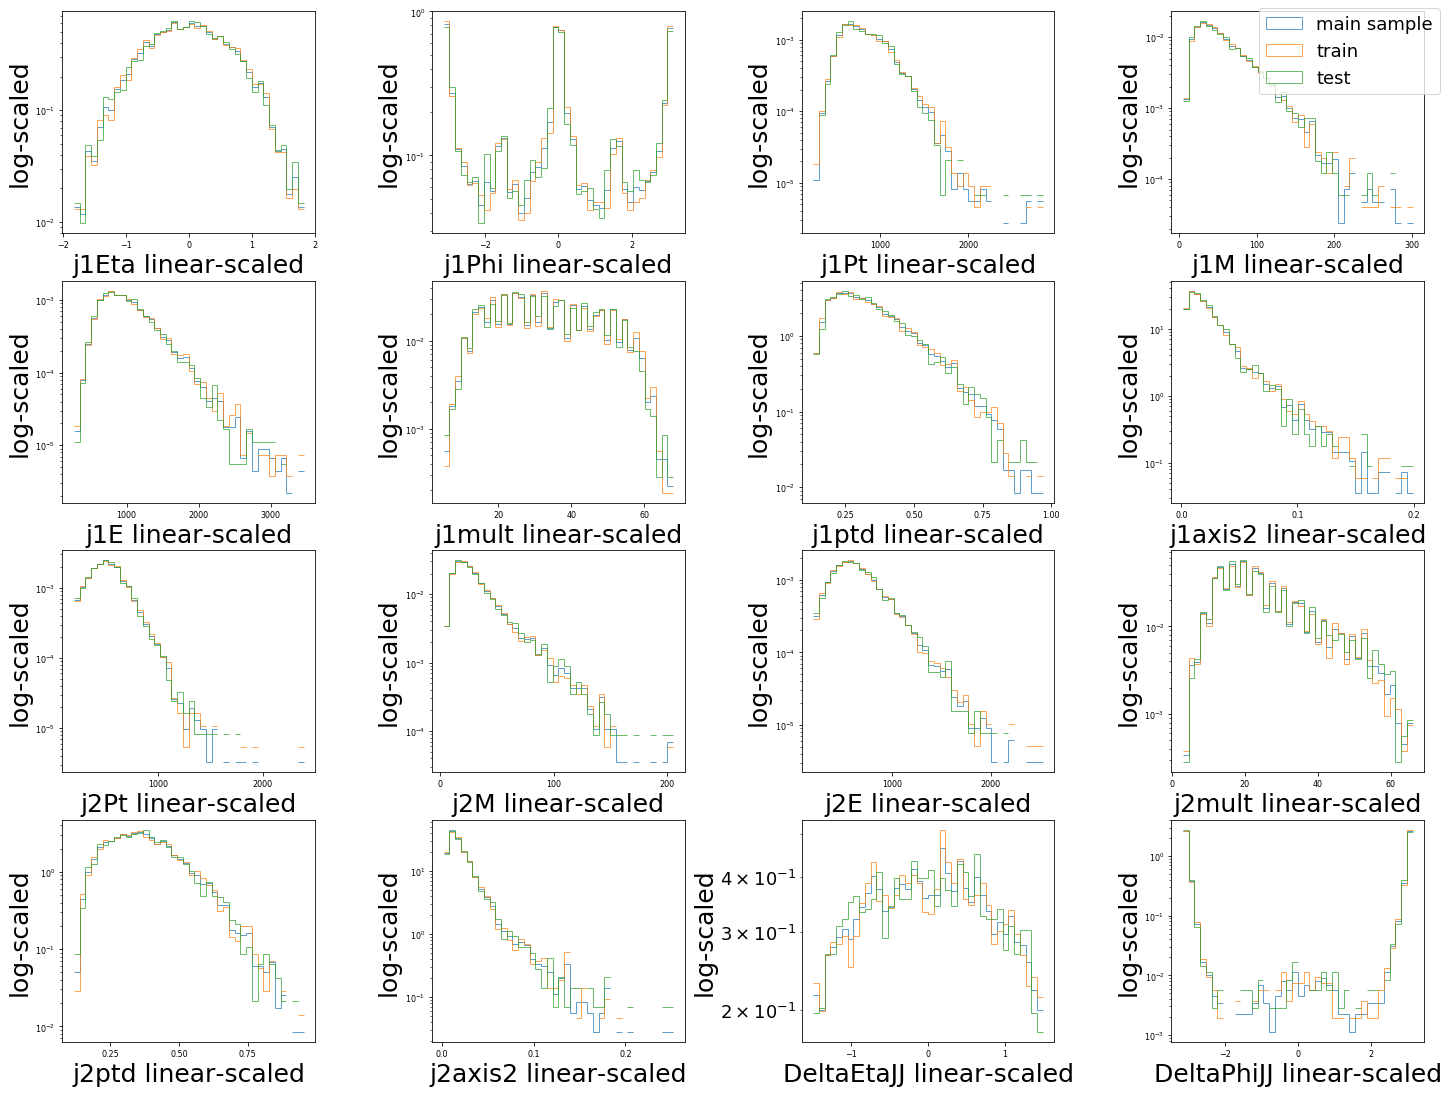

In [49]:
data.plot([train, test], normed=1, bins=40, figsize=(20,15), fontsize=25, xscale="linear")
data.plot([train, test], normed=1, bins=40, figsize=(20,15), fontsize=25, yscale="log")

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [13]:
ask = skeletons.autoencoder_skeleton()
ask.add(data.shape[1])
ask.add(30)
ask.add(9)
ask.add(30)
ask.add(16)

autoencoder = ask.build()
encoder, decoder = autoencoder.layers[1:]

... and the model summaries:

In [14]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()

encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
layer_2 (Dense)              (None, 30)                510       
_________________________________________________________________
layer_3 (Dense)              (None, 9)                 279       
Total params: 789
Trainable params: 789
Non-trainable params: 0
_________________________________________________________________


decoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_3 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
layer_4 (Dense)              (None, 30)                300       
__________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [15]:
name = "deep_9_4"
trainer = skeletons.training_skeleton(os.path.join("data/training_runs/16hlf", name))

train_shell :: locking file '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/autoencode/data/training_runs/16hlf/deep_9_4.h5'
h5_elt 'metric_names' :: creating group 'data' in file 'deep_9_4.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'deep_9_4.h5'
h5_elt 'training' :: creating group 'params' in file 'deep_9_4.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'deep_9_4.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'deep_9_4.h5'
train_shell :: unlocking file 'deep_9_3.h5'


training is easy:

In [18]:
autoencoder = trainer.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss="mse",
    epochs=20,
    model=autoencoder,
    metrics=['mae'],
    force=False,
    batch_size=16,
)

train_shell :: ERROR: IGNORING PASSED PARAMETER 'model'
train_shell :: using saved model
train_shell :: TRAINING EPOCH 10/20
Train on 3370 samples, validate on 2248 samples
Epoch 11/11
210/210 [==============================] - 5s 21ms/step - loss: 0.0023 - mean_absolute_error: 0.0321 - val_loss: 0.0022 - val_mean_absolute_error: 0.0316
train_shell :: TRAINING EPOCH 11/20
Train on 3370 samples, validate on 2248 samples
Epoch 12/12
210/210 [==============================] - 3s 15ms/step - loss: 0.0021 - mean_absolute_error: 0.0306 - val_loss: 0.0021 - val_mean_absolute_error: 0.0302
train_shell :: TRAINING EPOCH 12/20
Train on 3370 samples, validate on 2248 samples
Epoch 13/13
210/210 [==============================] - 4s 19ms/step - loss: 0.0020 - mean_absolute_error: 0.0293 - val_loss: 0.0020 - val_mean_absolute_error: 0.0292
train_shell :: TRAINING EPOCH 13/20
Train on 3370 samples, validate on 2248 samples
Epoch 14/14
210/210 [==============================] - 3s 16ms/step - loss: 0

... as is checking results:
### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

data_table :: plotting distrubution(s) for table(s) ['main sample', 'pred']


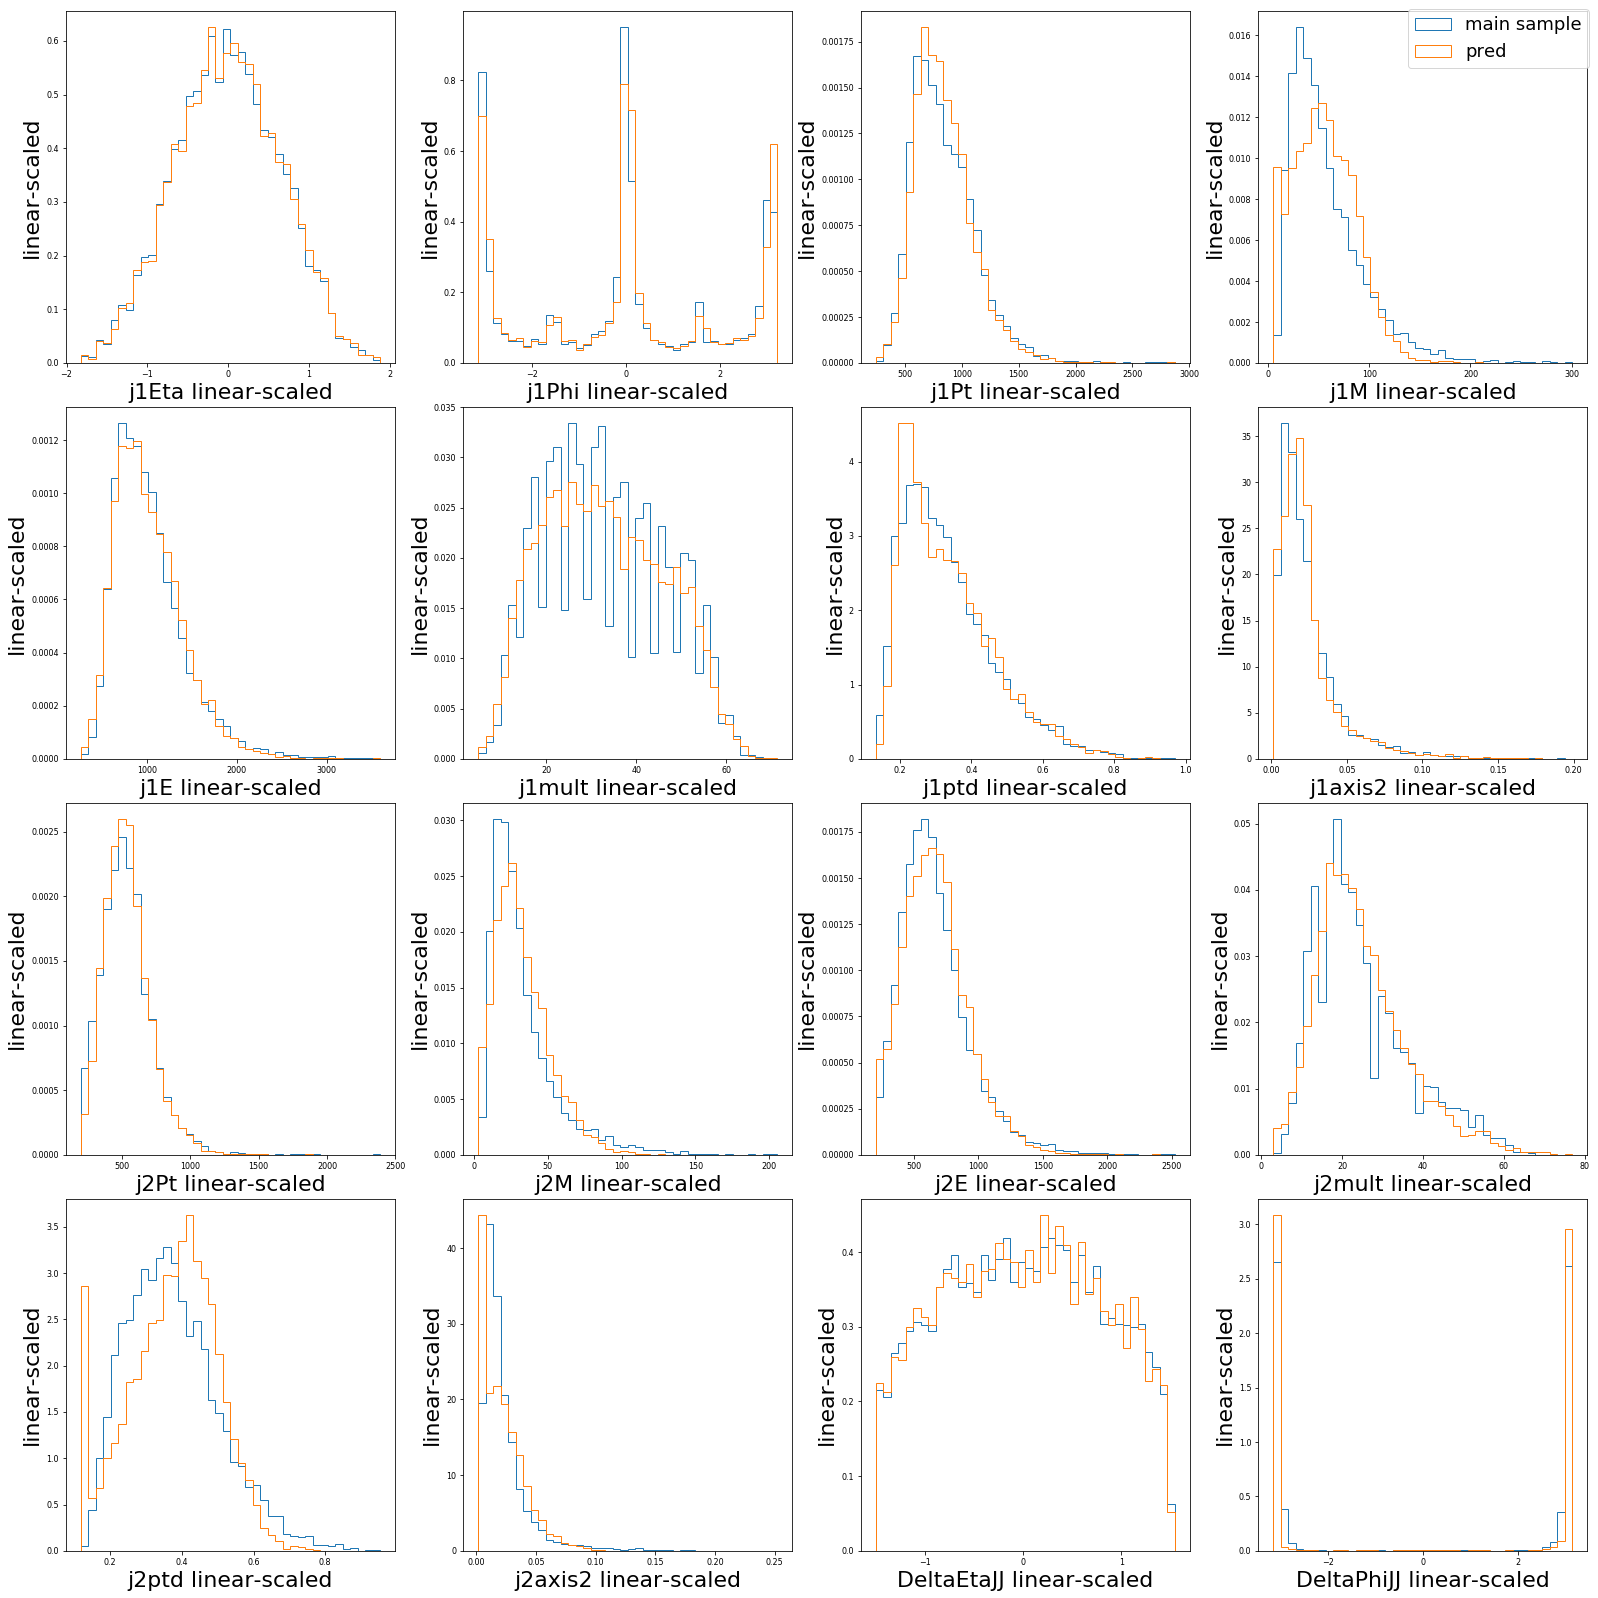

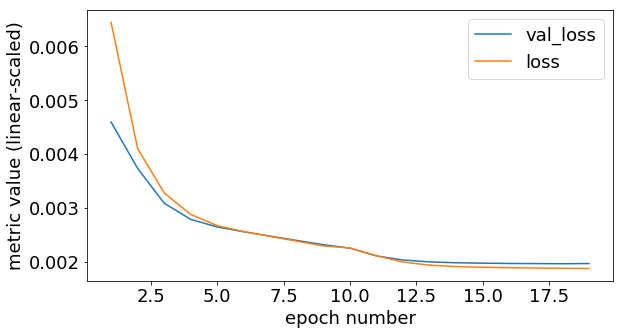

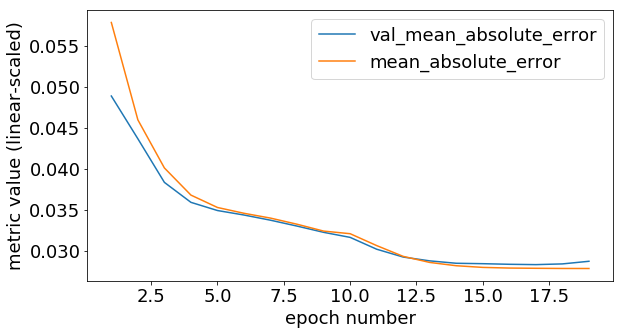

In [20]:
recon_norm = utils.data_table(autoencoder.predict(data.norm().data), headers=data.headers)
recon = data.inorm(recon_norm)
recon.name = "pred"
data.plot(
    [recon],
    normed=1, bins=40, alpha=1.0, figloc="upper right",
    figsize=(22,22), fontsize=22
)

trainer.plot_metrics(fnmatch_criteria="*loss*", yscale="linear", figsize=(9,5))
trainer.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear", figsize=(9,5))

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


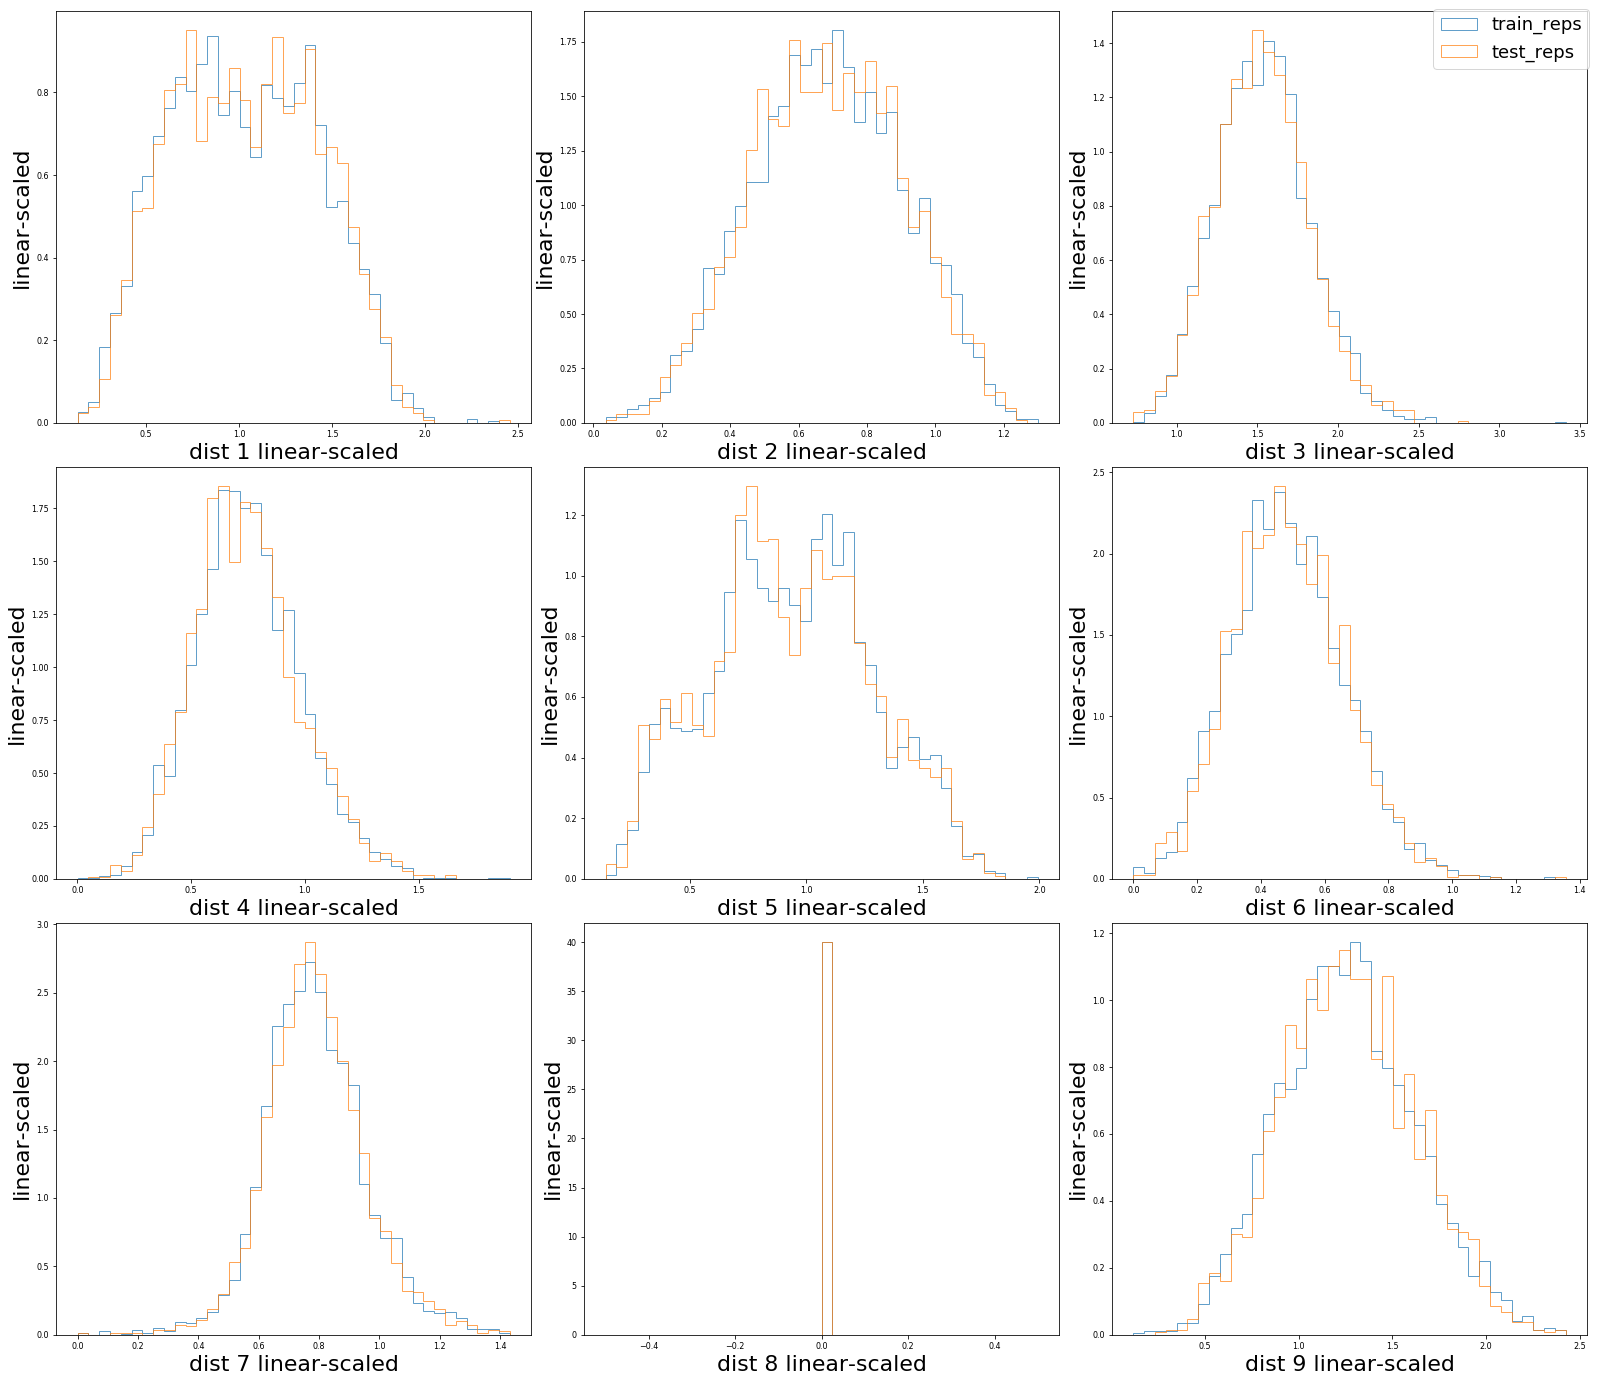

In [23]:
encoder, decoder = autoencoder.layers[1:]

train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)
train_reps.plot([test_reps], cols=3, figsize=(22,19), fontsize=22, bins=40, normed=1)

# train_reconstructed_norm = utils.data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
# test_reconstructed_norm = utils.data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)
# recon_norm = utils.data_table(autoencoder.predict(data.norm().data), headers=data.headers)

# train_reconstructed = data.inorm(train_reconstructed_norm)
# test_reconstructed = data.inorm(test_reconstructed_norm)
# recon = data.inorm(recon_norm)

# train_reconstructed.name = "train reconstructed"
# test_reconstructed.name = "test reconstructed"
# recon.name = "pred"

# # train.plot([train_reconstructed], bins = 30, alpha=1.0)
# # test.plot([test_reconstructed], bins=30, alpha=1.0)
# data.plot(
# #     [train_reconstructed, test_reconstructed],
#     [recon],
#     normed=1, bins=40, alpha=1.0, figloc="upper right",
#     figsize=(22,22), fontsize=22
# )

data_table :: plotting distrubution(s) for table(s) ['error']


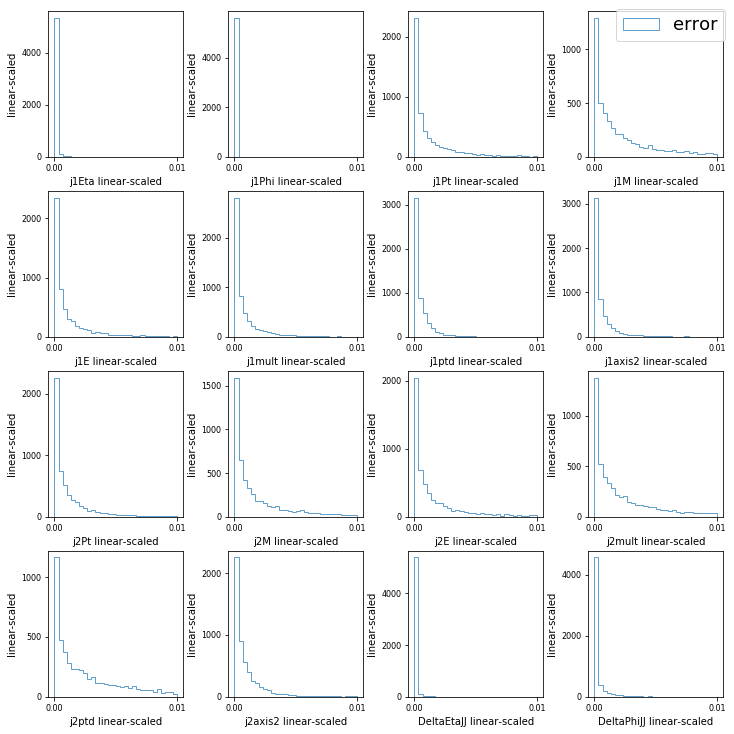

In [46]:
err = utils.data_table((data.norm().df - recon_norm.df)**2., data.headers, "error")
err.plot(bins=30, rng=(0,0.01), yscale='linear')
